# Grouping hospitals by similarities in decision making

## Aims

* To place hospitals into groups according to their decision making such that hospitals in the same group make similar decisions. This is done based on Hamming distance - the proportion of patients with an agreed decision between two hospitals.

To identify groups of similar hospitals we:

- Use pre-trained hospital models
- Put the unseen cohort of 10,000 patients through all hospital models
- Find the hamming distance between predicted outcomes in the cohort for every pair of hospitals and store in a distance matrix $D$
- Seriate $D$ to visualise hospital groups 

We follow this by repeating the analysis a subgroup of hospitals - those with 30-70% agreement to thrombolyse between hospitals (so we remove those patients high agreement on thrombolysis decision).

## Import libraries 

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.spatial.distance import hamming
from seriate import seriate

## Load pre-trained hospital models 

In [3]:
with open ('./models/trained_hospital_models_for _cohort.pkl', 'rb') as f:
    
    hospital_models = pkl.load(f)

## Load cohort 

The 10k test cohort was not used in training the models used.

In [4]:
data_loc = '../data/10k_training_test/'
cohort = pd.read_csv(data_loc + 'cohort_10000_test.csv')

In [5]:
cohort

,StrokeTeam,S1AgeOnArrival,S1OnsetToArrival_min,S2RankinBeforeStroke,Loc,LocQuestions,LocCommands,BestGaze,Visual,FacialPalsy,...,S2NewAFDiagnosis_Yes,S2NewAFDiagnosis_missing,S2StrokeType_Infarction,S2StrokeType_Primary Intracerebral Haemorrhage,S2StrokeType_missing,S2TIAInLastMonth_No,S2TIAInLastMonth_No but,S2TIAInLastMonth_Yes,S2TIAInLastMonth_missing,S2Thrombolysis
0,LGNPK4211W,67.5,193.0,1,0,2.0,0.0,0.0,0.0,0.0,...,0,1,0,1,0,0,0,0,1,0
1,LZGVG8257A,62.5,54.0,2,0,0.0,0.0,0.0,0.0,0.0,...,0,1,1,0,0,0,0,0,1,0
2,DNOYM6465G,82.5,173.0,0,0,0.0,0.0,0.0,0.0,1.0,...,0,1,1,0,0,0,0,0,1,0
3,ISIZF6614O,72.5,159.0,1,0,2.0,0.0,0.0,2.0,0.0,...,0,0,1,0,0,0,0,0,1,0
4,NGKDE7265L,87.5,145.0,0,0,0.0,0.0,0.0,0.0,1.0,...,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,NFBUF0424E,57.5,99.0,0,1,2.0,2.0,1.0,2.0,2.0,...,0,1,0,1,0,0,0,0,1,0
9996,UJETD9177J,87.5,159.0,3,0,2.0,2.0,0.0,0.0,0.0,...,0,1,1,0,0,0,0,0,1,1
9997,BICAW1125K,67.5,142.0,0,0,0.0,0.0,0.0,2.0,0.0,...,0,0,1,0,0,0,0,0,1,0
9998,CYVHC2532V,72.5,101.0,0,0,0.0,0.0,0.0,0.0,1.0,...,0,1,1,0,0,0,0,0,1,0


## Put 10k cohort through all hospital models 

In [6]:
hospitals = list(hospital_models.keys())

results = pd.DataFrame(columns = hospitals, index = cohort.index.values)
    
for hospital_train in hospitals:
   
    test_patients = cohort
    
    y = test_patients['S2Thrombolysis']
    X = test_patients.drop(['StrokeTeam','S2Thrombolysis'], axis=1)

    model = hospital_models[hospital_train][0]

    y_pred = model.predict(X)

    new_column = pd.Series(y_pred, name=hospital_train, index=test_patients.index.values)
        
    results.update(new_column)

## Find hamming distance between hospitals

Hamming distance is a metric for comparing two binary data strings. While comparing two binary strings of equal length, Hamming distance is the number of bit positions in which the two bits are different. Our binary data is whether a hospital is predicted to give thrombolysis or not to each of the cohort of patients.

In [7]:
D = np.ones((results.shape[1],results.shape[1]))

for i,h1 in enumerate(results.columns):
    
    for j,h2 in enumerate(results.columns):
        
        D[i,j] = hamming(results[h1], results[h2])

Show min and max Hamming.

In [8]:
np.min(D), np.max(D)

(0.0, 0.4474)

Plot Hamming distances

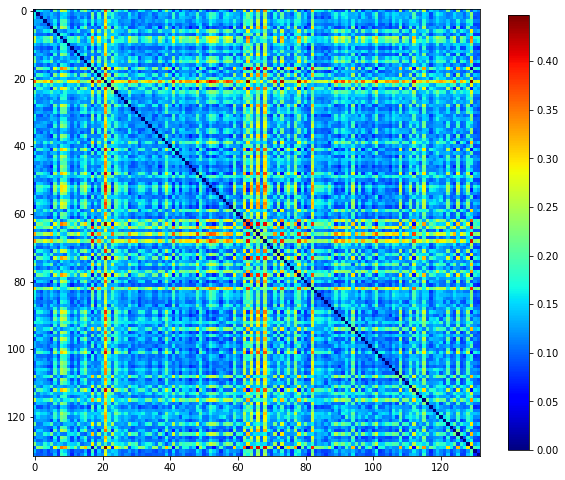

In [9]:
fig, ax = plt.subplots(figsize=(10,10))

im = ax.imshow(D, cmap=plt.get_cmap('jet'))
plt.colorbar(im, shrink = 0.8)

plt.savefig('output/hamming_not_sorted.jpg', dpi=300)

plt.show()

Seriate (sort) distance matrix. Seriation moves similar valued points together.

In [10]:
order = seriate(D)

In [11]:
new_D = np.zeros_like(D)

for i,o in enumerate(order):
    
    for j,o2 in enumerate(order):
        
        new_D[i,j] = D[o,o2]

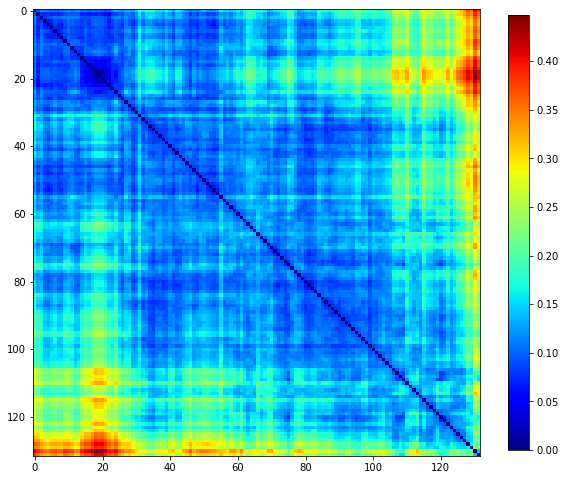

In [12]:
fig, ax = plt.subplots(figsize=(10,10))

im = ax.imshow(new_D, cmap=plt.get_cmap('jet'))
plt.colorbar(im, shrink = 0.8)

plt.savefig('output/hamming_seriated.jpg', dpi=300)

plt.show()

## Use 'contentious' patients to determine hospital distance

We define 'contentious' patients as those patients with a low level of agreement between hospitals.

For each patient, calculate the percentage of hospitals that agree on the decision to thrombolyse or not.

In [13]:
results['sum'] = results.sum(axis=1)

results['percent'] = results['sum']/len(hospitals)

results['percent_agree'] = [max(p, 1-p) for p in results['percent']]

In [14]:
results

,WJHSV5358P,TPFFP4410O,YQMZV4284N,SJVFI6669M,ISIZF6614O,OKVRY7006H,QOAPO4699N,OFKDF3720W,NTPQZ0829K,HBFCN1575G,...,PDNWI2057P,HYNBH3271L,TFSJP6914B,AKCGO9726K,LFPMM4706C,EQZZZ5658G,UIWEN7236N,sum,percent,percent_agree
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.000000,1.000000
1,0,1,1,0,0,0,1,0,1,1,...,1,0,0,1,0,1,0,46.0,0.348485,0.651515
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.000000,1.000000
3,0,0,1,1,1,0,1,1,1,1,...,1,1,0,1,0,0,0,61.0,0.462121,0.537879
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4.0,0.030303,0.969697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.0,0.007576,0.992424
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,6.0,0.045455,0.954545
9997,0,1,1,0,1,0,1,1,1,1,...,1,0,0,0,0,1,1,56.0,0.424242,0.575758
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.000000,1.000000


Extract cohort patients that only 30-70% of hospitals would thrombolyse

In [15]:
contentious = results[results['percent_agree']<=0.7]

In [16]:
contentious = contentious.drop(['sum', 'percent', 'percent_agree'], axis=1)

Show number of contentious patients.

In [17]:
number_contentious  = contentious.shape[0]
print (f'Number of contentious patients: {number_contentious}')

Number of contentious patients: 1410


### Re-calculate hamming distance based on contentious patients 

In [18]:
D = np.ones((contentious.shape[1],contentious.shape[1]))

for i,h1 in enumerate(contentious.columns):
    
    for j,h2 in enumerate(contentious.columns):
        
        D[i,j] = hamming(contentious[h1], contentious[h2])

#### Seriate 

In [19]:
order = seriate(D)

new_D = np.zeros_like(D)

for i,o in enumerate(order):
    
    for j,o2 in enumerate(order):
        
        new_D[i,j] = D[o,o2]      

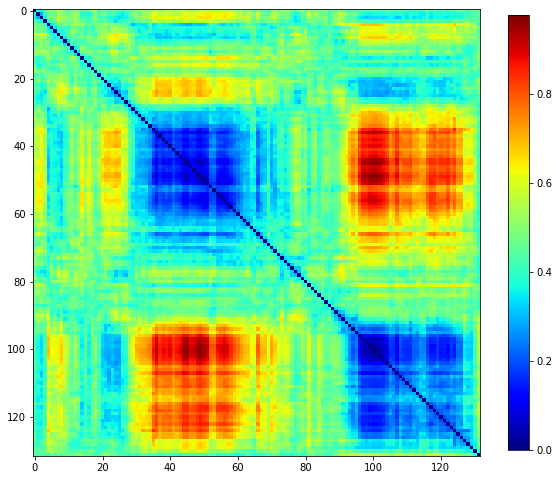

In [20]:
fig, ax = plt.subplots(figsize=(10,10))

im = ax.imshow(new_D, cmap=plt.get_cmap('jet'))
plt.colorbar(im, shrink = 0.8)

plt.savefig('output/hamming_seriated_30_to_70_percent_agree.jpg', dpi=300)

plt.show()

Get thrombolysis use in two groups of hospital, IDs 35-60, and IDs 95-120.

In [21]:
index = order[35:61]
hospitals = contentious.columns[index]
rate = np.mean(contentious[hospitals].mean(axis=1))
print (f'Thrombolysis rate {rate:0.3f}')

Thrombolysis rate 0.896


In [22]:
index = order[95:126]
hospitals = contentious.columns[index]
rate = np.mean(contentious[hospitals].mean(axis=1))
print (f'Thrombolysis rate {rate:0.3f}')

Thrombolysis rate 0.131


Get thrombolysis use in a neutral area (e.g hospitals 75 to 85).

In [23]:
index = order[75:86]
hospitals = contentious.columns[index]
rate = np.mean(contentious[hospitals].mean(axis=1))
print (f'Thrombolysis rate {rate:0.3f}')

Thrombolysis rate 0.518


## Observations 

* Using all patients in the cohort, the pairwise hamming distance between hospitals is relatively low. 

* Using only 'contentious' patients in the cohort (i.e. patients that only 30-70% of hospitals would thrombolyse) we find that there are two distinct groups of hospitals, representing two types of decision making processes.

* Within each group, there are sub-groups of hospitals that are more similar to one another than other hospitals in the same group.

* The two identified groups have very different thrombolysis use in the group of 'contentious patients. 13%.

* Use of patients groups with high predicted disagreement in decision-making facilitates identification of hospitals with similar decision-making.